# Artificial Neural Networks and Deep Learning











---











# Homework 1

In [1]:
# Todo (to improve model):

# dropout !!

# Add an edge detection technique on cell images

# Read on past solutions to this problem (papers)

## ⚙️ Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.gridspec as gridspec
import keras

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## ⏳ Load the Data

In [3]:
# Load Data
# data = np.load('clean_data.npz')
data = np.load("/kaggle/input/clean-set/clean_data.npz")
X = data["images"]
y = data["labels"]
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([ 852, 2181, 1085, 2026,  849,  993, 2330, 1643]))

In [4]:
# Labels dictionary
labels_dict = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

In [5]:
class_count = {}

for i in labels_dict:
    class_count[i] = np.unique(y, return_counts=True)[1][i]

class_count

{0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}

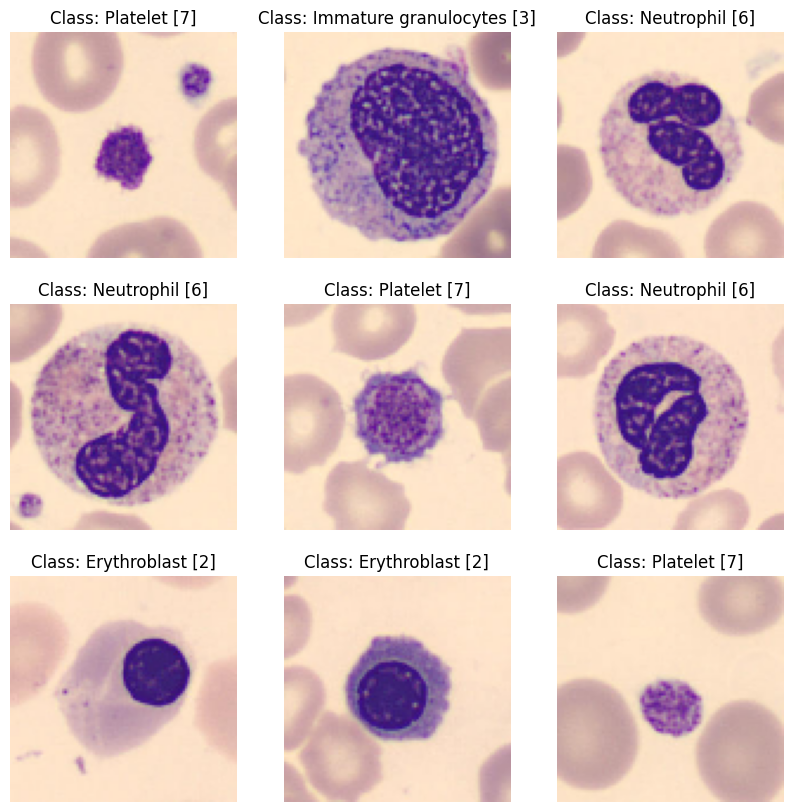

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.reshape((-1,))

for i in range(9):

    axs[i].imshow(X[i])

    axs[i].set_title(f"Class: {labels_dict[y[i][0]]} {y[i]}")

    axs[i].axis("off")


## 🔄 Process Data


In [7]:
# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

test_val_size = 0.05 # parameter to tune

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=test_val_size, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (10763, 96, 96, 3), y_train shape: (10763, 8)
X_val shape: (598, 96, 96, 3), y_val shape: (598, 8)
X_test shape: (598, 96, 96, 3), y_test shape: (598, 8)


## 🧮 Define Network Parameters


In [8]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [9]:
#Number of training epochs
epochs = 5 # parameter to tune

# Batch size for training
batch_size = 64 # parameter to tune

# Learning rate: step size for updating the model's weights
learning_rate = 0.001 # parameter to tune

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Epochs: 5
Batch Size: 64
Learning Rate: 0.001


## 🛠️ Build the Model

1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


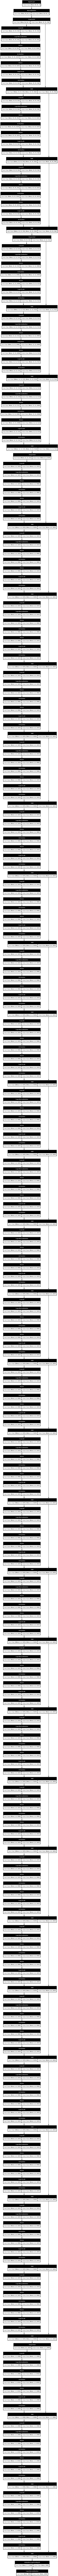

In [10]:
model_large = keras.applications.ConvNeXtXLarge(
    include_top=False, #can change this
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling="avg", #can change this
    classes=8,
    classifier_activation="softmax"    
)
tfk.utils.plot_model(model_large, show_shapes=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_flip_3 (RandomFlip) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_translation_3       │ (None, 96, 96, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_rotation_3          │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_zoom_3 (RandomZoom) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_xlarge (Functional)    │ (None, 2048)           │   348,147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer (InputLayer)   │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 96, 96, 3)      │             0 │
│ convnext_xlarge_prestem_normal… │                        │               │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ convnext_xlarge_stem       │ (None, 24, 24, 256)    │        13,056 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └                         │ (None, 24, 24, 256)    │        12,544 │
│ convnext_xlarge_stem_conv       │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └                         │ (None, 24, 24, 256)    │           512 │
│ convnext_xlarge_stem_layernorm  │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 256)    │        12,800 │
│ convnext_xlarge_stage_0_block_… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 256)    │           512 │
│ convnext_xlarge_stage_0_block_… │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 1024)   │       263,168 │
│ convnext_xlarge_stage_0_block_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 1024)   │             0 │
│ convnext_xlarge_stage_0_block_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 349,374,088 (1.30 GB)

 Trainable params: 1,220,232 (4.65 MB)

 Non-trainable params: 348,153,856 (1.30 GB)

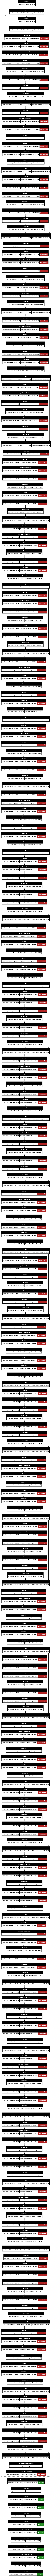

In [26]:
model_large.trainable = False #We freeze the weights of the CNN
tf.random.set_seed(seed)

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
], name='Augmentation')

x = augmentation(inputs)

# Connect ConvNeXtXLarge to the input
x = model_large(x)

###################################################################################################
# Adding additional layers here
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)

x = tfkl.Dense(512, activation='relu', name='dense1')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)

x = tfkl.Dense(256, activation='relu', name='dense2')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)

x = tfkl.Dense(128, activation='relu', name='dense3')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)
###################################################################################################
# Add a Dense layer with 8 units and softmax activation as the classifier
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
#AdamW(1e-4, weight_decay=5e-4)
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

# Display a summary of the model architecture
model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ Train and Save the Model

In [27]:
# Define the patience value for early stopping
patience = 10 # parameter to tune

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

#tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=25, min_lr=1e-5, mode='max')
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=patience, min_lr=1e-6, verbose=1
)
# Store the callback in a list
callbacks = [early_stopping, reduce_lr]

In [28]:
X_train.shape,y_train.shape

((10763, 96, 96, 3), (10763, 8))

In [29]:
'''history = model.fit(
    x = X_train_augmented_shuffled*255.0, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train_augmented_shuffled,
    batch_size=64,
    epochs = 10,
    validation_data = (X_val*255.0, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = callbacks
).history'''

# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=2,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_large.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/2
169/169 ━━━━━━━━━━━━━━━━━━━━ 611s 4s/step - accuracy: 0.4771 - loss: 1.7217 - val_accuracy: 0.7542 - val_loss: 0.7504 - learning_rate: 0.0010
Epoch 2/2
169/169 ━━━━━━━━━━━━━━━━━━━━ 591s 3s/step - accuracy: 0.7060 - loss: 0.8481 - val_accuracy: 0.8445 - val_loss: 0.4705 - learning_rate: 0.0010
Final validation accuracy: 84.45%


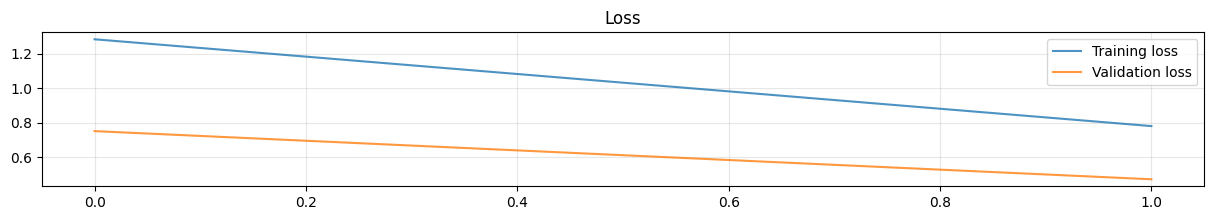

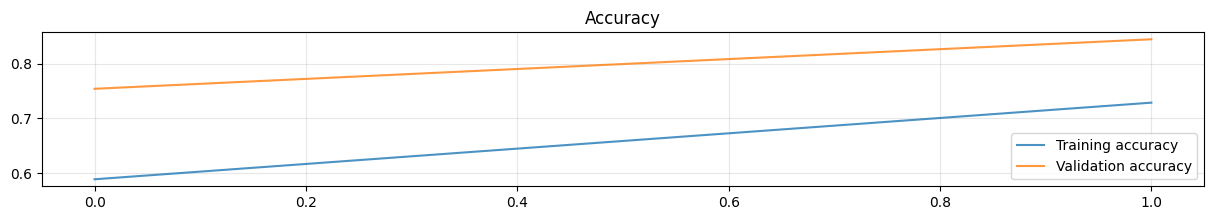

In [30]:
# Plot training and validation loss

plt.figure(figsize=(15, 2))
plt.plot(history["loss"], label="Training loss", alpha=0.8)
plt.plot(history["val_loss"], label="Validation loss", alpha=0.8)
plt.title("Loss")
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history["accuracy"], label="Training accuracy", alpha=0.8)
plt.plot(history["val_accuracy"], label="Validation accuracy", alpha=0.8)
plt.title("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [31]:
# Load the saved model

# model = tfk.models.load_model('cell.keras')

model = tfk.models.load_model('/kaggle/working/model_large.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Augmentation (Sequential)   │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip_3          │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation_3   │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation_3      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_zoom_3          │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomZoom)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ convnext_xlarge             │ (None, 2048)          │ 348,147,9… │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer            │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 96, 96, 3)     │          0 │   -   │
│ convnext_xlarge_prestem_no… │                       │            │       │
│ (Normalization)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ convnext_xlarge_stem   │ (None, 24, 24, 256)   │     13,056 │   Y   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └                     │ (None, 24, 24, 256)   │     12,544 │   N   │
│ convnext_xlarge_stem_conv   │                       │            │       │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └                     │ (None, 24, 24, 256)   │        512 │   N   │
│ convnext_xlarge_stem_layer… │                       │            │       │
│ (LayerNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 256)   │     12,800 │   N   │
│ convnext_xlarge_stage_0_bl… │                       │            │       │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 256)   │        512 │   N   │
│ convnext_xlarge_stage_0_bl… │                       │            │       │
│ (LayerNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 1024)  │    263,168 │   N   │
│ convnext_xlarge_stage_0_bl… │                       │            │       │
│ (Dense)                     │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼─────

 Total params: 351,814,554 (1.31 GB)

 Trainable params: 1,220,232 (4.65 MB)

 Non-trainable params: 348,153,856 (1.30 GB)

 Optimizer params: 2,440,466 (9.31 MB)

598
Accuracy score over the test set: 0.8495
Precision score over the test set: 0.8666
Recall score over the test set: 0.8495
F1 score over the test set: 0.8433


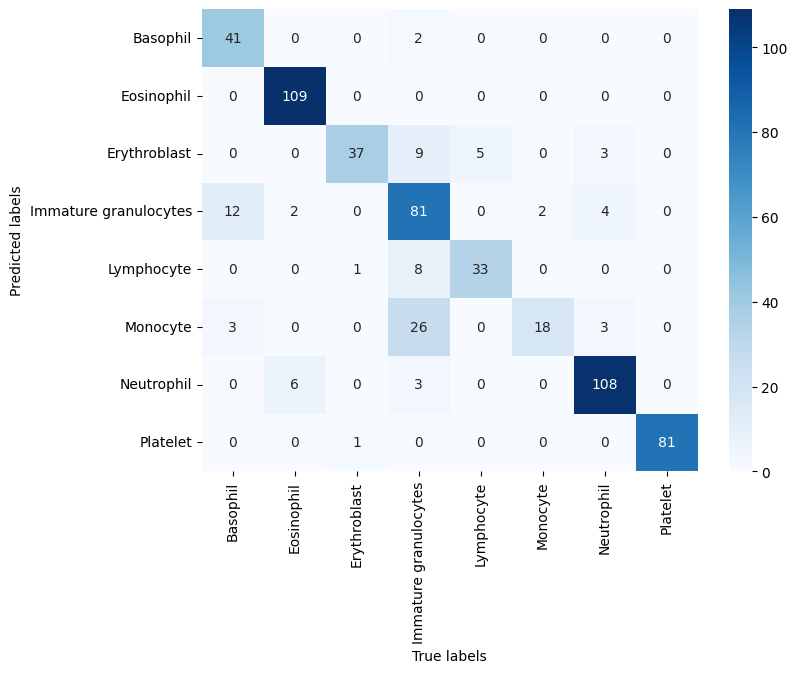

In [32]:
# Predict class probabilities and get predicted classes

test_predictions = model.predict(X_test, verbose=0)
print(len(test_predictions))
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f"Accuracy score over the test set: {round(test_accuracy, 4)}")

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average="weighted")
print(f"Precision score over the test set: {round(test_precision, 4)}")

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average="weighted")
print(f"Recall score over the test set: {round(test_recall, 4)}")

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average="weighted")
print(f"F1 score over the test set: {round(test_f1, 4)}")

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    xticklabels=list(labels_dict.values()),
    yticklabels=list(labels_dict.values()),
    cmap="Blues",
)

plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()

## 📊 Prepare Your Submission


To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:


```python

# file: model.py

class Model:

    def __init__(self):


        """Initialize the internal state of the model."""


    def predict(self, X):


        """Return a numpy array with the labels corresponding to the input X."""

```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.


❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [33]:
%%writefile model.py

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:

    def __init__(self):

        """

        Initialize the internal state of the model. Note that the __init__

        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained

        model.

        """

        self.neural_network = tfk.models.load_model('model_large.keras')


    def predict(self, X):

        """

        Predict the labels corresponding to the input X. Note that X is a numpy

        array of shape (n_samples, 96, 96, 3) and the output should be a numpy

        array of shape (n_samples,). Therefore, outputs must no be one-hot

        encoded.

        The following is an example of a prediction from the pre-trained model

        loaded in the __init__ method.

        """

        preds = self.neural_network.predict(X, verbose=0)

        # Get the predicted classes, not the one-hot encoded values
        preds = np.argmax(preds, axis=-1)

        return preds


Overwriting model.py


In [34]:
from datetime import datetime

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py model_large.keras

# from google.colab import files
# files.download(filename)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: model.py (deflated 56%)
  adding: model_large.keras (deflated 7%)


In [35]:
filename

'submission_241111_234447.zip'